**A.** Préliminaires

**A.1.** Imports :

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir as ls
from os.path import join
import time
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn   
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import copy
import pickle
import time

In [ ]:
help(transforms.ElasticTransform)

**A.2.** Montage du répertoire contenant les sources et le dataset :

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount('/gdrive')

Mounted at /gdrive


**A.3.** imports locaux 

In [ ]:
# os.chdir('/content/drive/MyDrive/sameCamera/src_real')
os.chdir('/gdrive/MyDrive/sameCamera/src_real')

In [ ]:
from archis_mtl import *
from utile_mtll import *

**A.4** Copie des répertoires et chemin

In [ ]:
dir_train = '/root/ds_sameCamera/ds_sameCamera_train'
dir_val = '/root/ds_sameCamera/ds_sameCamera_val'
dir_test = '/root/ds_sameCamera/ds_sameCamera_test'

In [ ]:
# ! tar -cf ../ds_sameCamera/ds_sameCamera_train.tar   ../ds_sameCamera/ds_sameCamera_train
# ! tar -cf ../ds_sameCamera/ds_sameCamera_val.tar   ../ds_sameCamera/ds_sameCamera_val
# ! tar -cf ../ds_sameCamera/ds_sameCamera_test.tar   ../ds_sameCamera/ds_sameCamera_test

if not os.path.isdir('/root/ds_sameCamera/ds_sameCamera_train'):
  !cp -r ../ds_sameCamera/ds_sameCamera_train.tar	/root/
  !tar -xf  /root/ds_sameCamera_train.tar  -C /root/

  !cp -r ../ds_sameCamera/ds_sameCamera_val.tar	/root/
  !tar -xf  /root/ds_sameCamera_val.tar  -C /root

  # !cp -r ../ds_sameCamera/ds_sameCamera_test.tar	/root/
  # !tar -xf  /root/ds_sameCamera_test.tar  -C /root

**B** Transformations pour l'augmentation de données 

In [ ]:
from utile_datasets_transforms import *

**C.** Visualisation des données

In [ ]:
# Instance of transforms:
size_in = 256+32
size_out = 256-32
tr = tr_ReID_train(size_in, size_out)

# Instance of Dataset_ReID
K = 4
S = 2

kwargs = {'size_in': size_in,
          'size_out': size_out,
          'angle_max':20,
          'ph':0.20,  
          'pv':0.15,
          'marginsup':0.05,
          'margininf':0.05,
          'cropped_prop':0.8,
          'zoom':33
          }

ds_train = Dataset_ReID(dir_train, tr, K, S, **kwargs)    

batch_size = 8
dl_viz = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, 
                                       shuffle=True, num_workers=2)


In [ ]:
it = iter(dl_viz)

In [ ]:
imgs, labels, codes = next(it)


tensor([[ 2670,  2670,  2670,  2670,  2671,  2671,  2671,  2671],
        [19850, 19850, 19850, 19850, 19851, 19851, 19851, 19851],
        [ 9770,  9770,  9770,  9770,  9771,  9771,  9771,  9771],
        [ 4890,  4890,  4890,  4890,  4891,  4891,  4891,  4891],
        [ 1440,  1440,  1440,  1440,  1441,  1441,  1441,  1441],
        [18700, 18700, 18700, 18700, 18701, 18701, 18701, 18701],
        [ 8510,  8510,  8510,  8510,  8511,  8511,  8511,  8511],
        [17320, 17320, 17320, 17320, 17321, 17321, 17321, 17321]])


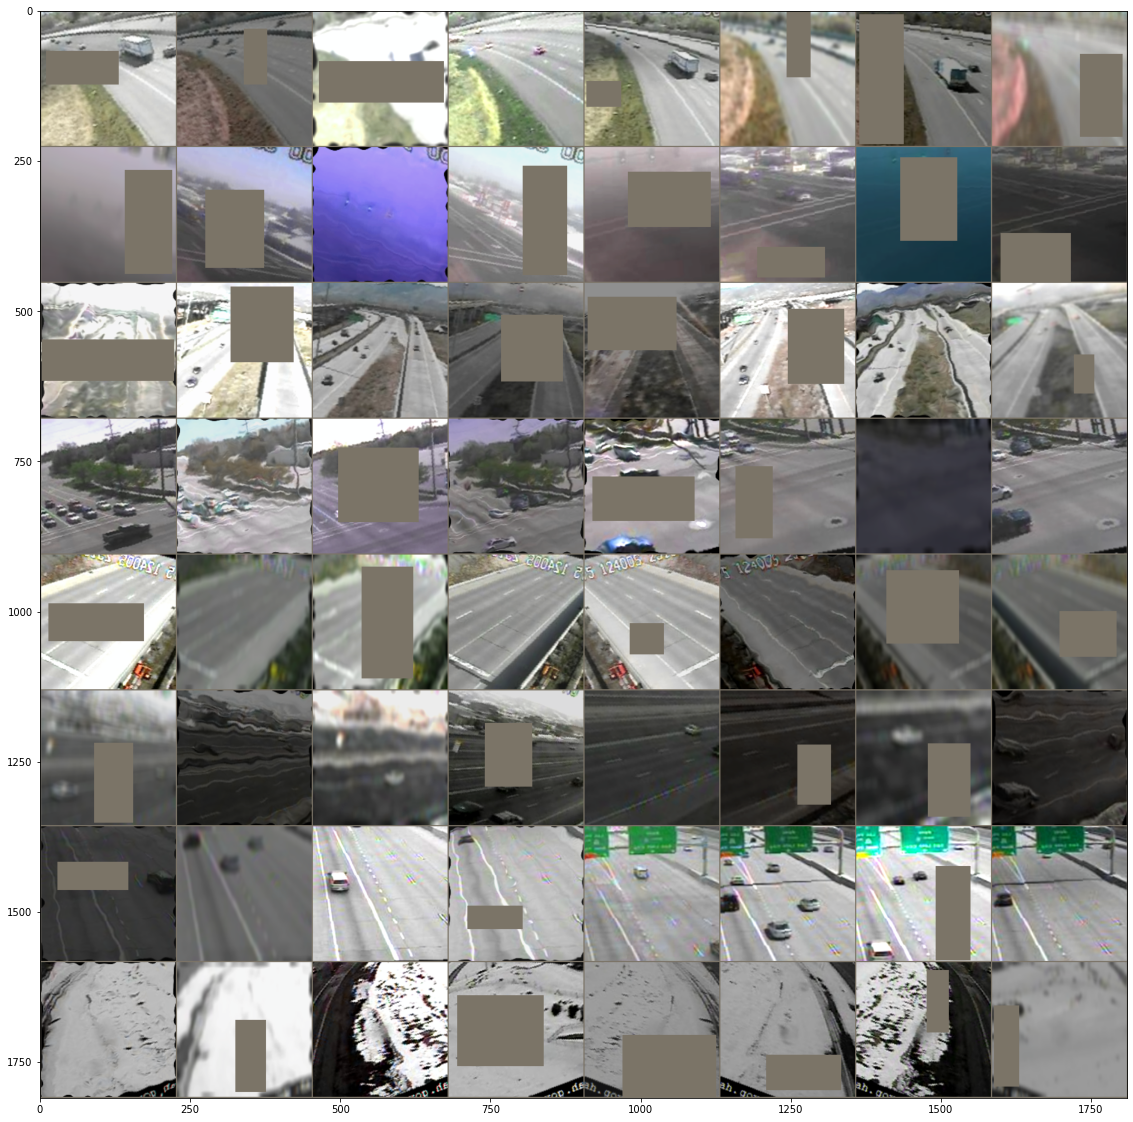

In [ ]:
def imshow(inp, title=None):
    #Imshow for Tensor
    plt.figure(figsize = (20,20))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Make a grid from batch
out = imgs.reshape((batch_size * K * S, 3, size_out, size_out))
out = torchvision.utils.make_grid(out)

#
print(labels)

imshow(out)

In [ ]:
print(codes[0]['angle'])
print(codes[1]['angle'])

print(codes[0]['perspective'][1])
print(codes[1]['perspective'][1])

print(codes[0]['cropping'])
print(codes[1]['cropping'])

print(codes[0]['flip'])
print(codes[1]['flip'])

tensor([-15,  15,   8, -11,  16, -19,  -2, -19])
tensor([  5,  -5, -12, -11,  16, -19,  -2, -19])
[[tensor([-42.5285, -13.0830, -38.5220, -53.3229, -42.4495,  -8.9549, -40.2439,
        -37.4216], dtype=torch.float64), tensor([-31.2293,  -1.3510, -38.4296, -18.8993, -20.8921,  -1.1491, -29.5600,
        -39.3835], dtype=torch.float64)], [tensor([320.8949, 314.7142, 316.6606, 344.4009, 316.2247, 290.1876, 295.2732,
        302.4020], dtype=torch.float64), tensor([-31.2293,  -1.3510, -38.4296, -18.8993, -20.8921,  -1.1491, -29.5600,
        -39.3835], dtype=torch.float64)], [tensor([294.6488, 295.3390, 325.5885, 290.4559, 322.2190, 288.2973, 311.9141,
        292.4778], dtype=torch.float64), tensor([317.5222, 302.7635, 322.9103, 325.2583, 318.7959, 298.9820, 298.4286,
        323.4838], dtype=torch.float64)], [tensor([-39.7936,  -3.8048,  -4.0905,  -3.6664, -17.6709, -42.1152, -40.5192,
        -28.5131], dtype=torch.float64), tensor([312.5090, 327.2341, 302.6837, 315.2698, 295.9571, 304

**D.** Entraînement

In [ ]:
from utile_trainReId import *

In [ ]:
# Instance of transforms:
size_in = 256+32
size_out = 256-32
tr = tr_ReID_train(size_in, size_out)

# Configuration
batch_size = 10
S = 2
K = 5
N = batch_size * S
Kval = 5
batch_size_val = 8
prodKS = {}
prodKS['train'] =  batch_size * S
prodKS['val'] =  batch_size_val * S

num_epochs = 100
lr = 0.0005 
num_latentdims = 100 


kwargs = {'size_in': size_in,
          'size_out': size_out,
          'angle_max':20,
          'ph':0.20,  
          'pv':0.15,
          'marginsup':0.05,
          'margininf':0.05,
          'cropped_prop':0.8,
          'zoom':33
          }

PATH_final_checkpoint = r"../models/modified_resnet50_final_checkpoint" 
PATH_bestacc_checkpoint = r"../models/modified_resnet50_bestacc_checkpoint"

In [ ]:
manualSeed = 0
torch.manual_seed(manualSeed)

#def loaders
ds_train = Dataset_ReID(dir_train, tr, K, S, **kwargs)    
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, 
                                       shuffle=True, num_workers=2)

ds_val = Dataset_ReID(dir_val, tr, Kval, S, **kwargs)    
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size_val, 
                                       shuffle=False, num_workers=2)

dl = {'train': dl_train, 'val':dl_val}

In [ ]:
# from https://github.com/mangye16/ReID-Survey/tree/master/modeling
# vient de https://arxiv.org/pdf/1711.07971.pdf

class Non_local(nn.Module):
    def __init__(self, in_channels, reduc_ratio=2):
        super(Non_local, self).__init__()

        self.in_channels = in_channels
        self.inter_channels = reduc_ratio//reduc_ratio

        self.g = nn.Conv2d(in_channels=self.in_channels, out_channels=self.inter_channels,
                      kernel_size=1, stride=1, padding=0)

        self.W = nn.Sequential(
            nn.Conv2d(in_channels=self.inter_channels, out_channels=self.in_channels,
                    kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(self.in_channels),
        )
        nn.init.constant_(self.W[1].weight, 0.0)
        nn.init.constant_(self.W[1].bias, 0.0)

        self.theta = nn.Conv2d(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)

        self.phi = nn.Conv2d(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        '''
                :param x: (b, t, h, w)
                :return x: (b, t, h, w)
        '''
        batch_size = x.size(0)
        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)
        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
        f = torch.matmul(theta_x, phi_x)
        N = f.size(-1)
        f_div_C = f / N

        y = torch.matmul(f_div_C, g_x)
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x
        return z


class GeneralizedMeanPooling(nn.Module):
    r"""Applies a 2D power-average adaptive pooling over an input signal composed of several input planes.
    The function computed is: :math:`f(X) = pow(sum(pow(X, p)), 1/p)`
        - At p = infinity, one gets Max Pooling
        - At p = 1, one gets Average Pooling
    The output is of size H x W, for any input size.
    The number of output features is equal to the number of input planes.
    Args:
        output_size: the target output size of the image of the form H x W.
                     Can be a tuple (H, W) or a single H for a square image H x H
                     H and W can be either a ``int``, or ``None`` which means the size will
                     be the same as that of the input.
    """

    def __init__(self, norm, output_size=1, eps=1e-6):
        super(GeneralizedMeanPooling, self).__init__()
        assert norm > 0
        self.p = float(norm)
        self.output_size = output_size
        self.eps = eps

    def forward(self, x):
        x = x.clamp(min=self.eps).pow(self.p)
        return torch.nn.functional.adaptive_avg_pool2d(x, self.output_size).pow(1. / self.p)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + str(self.p) + ', ' \
            + 'output_size=' + str(self.output_size) + ')'


class GeneralizedMeanPoolingP(GeneralizedMeanPooling):
    """ Same, but norm is trainable
    """
    def __init__(self, norm=3, output_size=1, eps=1e-6):
        super(GeneralizedMeanPoolingP, self).__init__(norm, output_size, eps)
        self.p = nn.Parameter(torch.ones(1) * norm)



In [ ]:
# import math

# import torch
# from torch import nn


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, last_stride=2, block=Bottleneck, layers=[3, 4, 6, 3]):
        self.inplanes = 64
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # self.relu = nn.ReLU(inplace=True)   # add missed relu
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=last_stride)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        # x = self.relu(x)    # add missed relu
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

    def load_param(self, model_path):
        param_dict = torch.load(model_path)
        for i in param_dict:
            if 'fc' in i:
                continue
            self.state_dict()[i].copy_(param_dict[i])

    def random_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


# import math

# import torch
# from torch import nn
# from modeling.layer.non_local import Non_local

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNetNL(nn.Module):
    def __init__(self, last_stride=2, block=Bottleneck, layers=[3, 4, 6, 3], non_layers=[0, 2, 3, 0]):
        self.inplanes = 64
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # self.relu = nn.ReLU(inplace=True)   # add missed relu
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=last_stride)

        self.NL_1 = nn.ModuleList(
            [Non_local(256) for i in range(non_layers[0])])
        self.NL_1_idx = sorted([layers[0] - (i + 1) for i in range(non_layers[0])])
        self.NL_2 = nn.ModuleList(
            [Non_local(512) for i in range(non_layers[1])])
        self.NL_2_idx = sorted([layers[1] - (i + 1) for i in range(non_layers[1])])
        self.NL_3 = nn.ModuleList(
            [Non_local(1024) for i in range(non_layers[2])])
        self.NL_3_idx = sorted([layers[2] - (i + 1) for i in range(non_layers[2])])
        self.NL_4 = nn.ModuleList(
            [Non_local(2048) for i in range(non_layers[3])])
        self.NL_4_idx = sorted([layers[3] - (i + 1) for i in range(non_layers[3])])

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        # x = self.relu(x)    # add missed relu
        x = self.maxpool(x)

        NL1_counter = 0
        if len(self.NL_1_idx) == 0: self.NL_1_idx = [-1]
        for i in range(len(self.layer1)):
            x = self.layer1[i](x)
            if i == self.NL_1_idx[NL1_counter]:
                _, C, H, W = x.shape
                x = self.NL_1[NL1_counter](x)
                NL1_counter += 1
        # Layer 2
        NL2_counter = 0
        if len(self.NL_2_idx) == 0: self.NL_2_idx = [-1]
        for i in range(len(self.layer2)):
            x = self.layer2[i](x)
            if i == self.NL_2_idx[NL2_counter]:
                _, C, H, W = x.shape
                x = self.NL_2[NL2_counter](x)
                NL2_counter += 1
        # Layer 3
        NL3_counter = 0
        if len(self.NL_3_idx) == 0: self.NL_3_idx = [-1]
        for i in range(len(self.layer3)):
            x = self.layer3[i](x)
            if i == self.NL_3_idx[NL3_counter]:
                _, C, H, W = x.shape
                x = self.NL_3[NL3_counter](x)
                NL3_counter += 1
        # Layer 4
        NL4_counter = 0
        if len(self.NL_4_idx) == 0: self.NL_4_idx = [-1]
        for i in range(len(self.layer4)):
            x = self.layer4[i](x)
            if i == self.NL_4_idx[NL4_counter]:
                _, C, H, W = x.shape
                x = self.NL_4[NL4_counter](x)
                NL4_counter += 1

        return x

    def load_param(self, model_path):
        param_dict = torch.load(model_path)
        for i in param_dict:
            if 'fc' in i:
                continue
            self.state_dict()[i].copy_(param_dict[i])

    def random_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [ ]:
import torch
from torch import nn
import collections
# from .backbones.resnet import ResNet, Bottleneck
# from .backbones.senet import SENet, SEResNetBottleneck, SEBottleneck, SEResNeXtBottleneck
# from .backbones.resnet_ibn_a import resnet50_ibn_a
# from .backbones.resnet_nl import ResNetNL
# from .layer import CrossEntropyLabelSmooth, TripletLoss, WeightedRegularizedTriplet, CenterLoss, GeneralizedMeanPooling, GeneralizedMeanPoolingP


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, a=0, mode='fan_out')
        if m.bias:
            nn.init.constant_(m.bias, 0.0)
    elif classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
        if m.bias:
            nn.init.constant_(m.bias, 0.0)
    elif classname.find('BatchNorm') != -1:
        if m.affine:
            nn.init.constant_(m.weight, 1.0)
            nn.init.constant_(m.bias, 0.0)


def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, std=0.001)
        if m.bias:
            nn.init.constant_(m.bias, 0.0)


class Baseline(nn.Module):
    

    def __init__(self, num_classes, last_stride, model_path, model_name, gem_pool, pretrain_choice):
      super(Baseline, self).__init__()
      self.in_planes = 2048
      self.use_classifier = False
      if model_name == 'resnet50':
          self.base = ResNet(last_stride=last_stride,
                              block=Bottleneck,
                              layers=[3, 4, 6, 3])
      elif model_name == 'resnet50_nl':
          self.base = ResNetNL(last_stride=last_stride,
                              block=Bottleneck,
                              layers=[3, 4, 6, 3],
                              non_layers=[0, 2, 3, 0])
      elif model_name == 'resnet101':
          self.base = ResNet(last_stride=last_stride,
                              block=Bottleneck,
                              layers=[3, 4, 23, 3])
      elif model_name == 'resnet152':
          self.base = ResNet(last_stride=last_stride,
                              block=Bottleneck,
                              layers=[3, 8, 36, 3])


      if pretrain_choice == 'imagenet':
          self.base.load_param(model_path)
          print('Loading pretrained ImageNet model......')

      self.num_classes = num_classes

      if gem_pool == 'on':
          print("Generalized Mean Pooling")
          self.global_pool = GeneralizedMeanPoolingP()
      else:
          print("Global Adaptive Pooling")
          self.global_pool = nn.AdaptiveAvgPool2d(1)

      self.bottleneck = nn.BatchNorm1d(self.in_planes)
      self.bottleneck.bias.requires_grad_(False)  # no shift
      self.classifier = nn.Linear(self.in_planes, self.num_classes, bias=False)

      self.bottleneck.apply(weights_init_kaiming)
      self.classifier.apply(weights_init_classifier)

    def forward(self, x):

        x = self.base(x)

        global_feat = self.global_pool(x)  # (b, 2048, 1, 1)
        global_feat = global_feat.view(global_feat.shape[0], -1)  # flatten to (bs, 2048)



        if self.use_classifier:
          feat = self.bottleneck(global_feat)  # normalize for angular softmax
          cls_score = self.classifier(feat)
          return cls_score, global_feat            
        else:
          return global_feat.reshape(global_feat.shape[0],-1)

"""
    def load_param(self, trained_path):
        param_dict = torch.load(trained_path)
        if not isinstance(param_dict, collections.OrderedDict):
            param_dict = param_dict.state_dict()
        for i in param_dict:
            if 'classifier' in i:
                continue
            self.state_dict()[i].copy_(param_dict[i])
"""
resnet = torchvision.models.resnet50(progress=True)
torch.save( resnet.state_dict(),'resnet.pt')

num_classes = num_latentdims
last_stride = 1 
model_path = ''
model_name = 'resnet50_nl' 
gem_pool = 'on'
pretrain_choice = 'imagenet'
num_latentdims = 2048
model = Baseline(num_classes, last_stride, 'resnet.pt', model_name, gem_pool, pretrain_choice)


Loading pretrained ImageNet model......
Generalized Mean Pooling


In [ ]:
imgs = imgs.reshape(imgs.shape[0]*imgs.shape[1],imgs.shape[2],imgs.shape[3],imgs.shape[4])

In [ ]:
imgs.shape

torch.Size([64, 3, 224, 224])

In [ ]:
model(imgs).shape

torch.Size([64, 2048])

In [ ]:
# def build_model(cfg, num_classes):
#     model = Baseline(num_classes, cfg.MODEL.LAST_STRIDE, cfg.MODEL.PRETRAIN_PATH, cfg.MODEL.NAME,
#                      cfg.MODEL.GENERALIZED_MEAN_POOL, cfg.MODEL.PRETRAIN_CHOICE)
#     return model


In [ ]:
# from bisect import bisect_right

# # Momentum
# _C.SOLVER.MOMENTUM = 0.9

# # Number of images per batch
# # This is global, so if we have 8 GPUs and IMS_PER_BATCH = 16, each GPU will
# # see 2 images per batch
# _C.SOLVER.IMS_PER_BATCH = 64

In [ ]:
# chargement/adaptation de la dernière couche du modèle:
"""
model = torchvision.models.resnet50(progress=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_latentdims)
"""

'\nmodel = torchvision.models.resnet50(progress=True)\nnum_ftrs = model.fc.in_features\nmodel.fc = nn.Linear(num_ftrs, num_latentdims)\n'

In [ ]:
model = model.cuda()

# Fonction de coût
margin = None
normalize_feature = False
tripletloss = TripletLoss(margin=margin)
tripletloss = WeightedRegularizedTriplet()

# Optim
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler_start = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=10)
scheduler_end = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
# init stats, best weights from scratch
"""
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_losses=[]
val_losses=[]
train_accs = []
val_accs = []
max_acc = 0
last_epoch = 0
"""

'\nbest_model_wts = copy.deepcopy(model.state_dict())\nbest_acc = 0.0\ntrain_losses=[]\nval_losses=[]\ntrain_accs = []\nval_accs = []\nmax_acc = 0\nlast_epoch = 0\n'

In [ ]:
# init stats, best weights from checkpoint

checkpoint = torch.load(PATH_bestacc_checkpoint)
train_losses = checkpoint['train_losses']

val_losses = checkpoint['val_losses']

train_accs = checkpoint['train_accs']
val_accs = checkpoint['val_accs']
max_acc = val_accs[-1]
last_epoch = checkpoint['epoch']
model_weights = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer_state_dict']
scheduler_start_state_dict = checkpoint['scheduler_start_state_dict']
scheduler_end_state_dict = checkpoint['scheduler_end_state_dict']
model.load_state_dict(model_weights)
optimizer.load_state_dict(optimizer_state_dict)
scheduler_start.load_state_dict(scheduler_start_state_dict)
scheduler_end.load_state_dict(scheduler_end_state_dict)

In [ ]:
def czech_distToCenters(feat):
  with torch.no_grad():
    bs, K, nld = feat.shape
    # czech-moyennes: de tailles bs, K, nld
    # on applatit les dim. 1,2 et on enlève le premier élément diag.
    # on met les termes diagonaux en fin de ligne et on les éjecte
    # on remet en forme

    means = feat.unsqueeze(dim=1)\
                .expand(bs,K,K,nld)\
                .reshape(bs,K*K,nld)[:,1:,:]\
                .view(bs,K-1,K+1,nld)[:,:,:-1,:]\
                .reshape(bs,K, K-1,nld)\
                .mean(dim=2)
    # means = feat.mean(dim=1)
    # distances aux moyennes:
    # on calcule distance(feat[i,k,:], means[l,k,:])
    dists = []
    for k in range(K):
      # distances élm. k x mean sans elmt k:
      dists.append(euclidean_dist(feat[:,k,:], means[:,k,:]).unsqueeze(1)) #[:,k,:]))
    
    return torch.cat(dists, dim=1).view(K*bs,bs)

"""
# pour le dév de czech_distToCenters:
import torch

a = torch.rand(5,4,3)
b = a.unsqueeze(dim=1).expand(5,4,4,3)

print(b.shape)
# option 1:
M = (torch.zeros(4,4) == 0)
M[range(4), range(4)] = False  
print(M)
print(b[:,M,:].shape)
print(a[:,1:,:].mean(dim = 1))
print(b[:,M,:].view(5,4,3,3).mean(dim = 2)[:,0,:])
# option 2, plus simple (pas de matrice supplémentaire)
print(a.unsqueeze(dim=1).expand(5,4,4,3).reshape(5,16,3)[:,1:,:].view(5,4-1,4+1,3)[:,:,:-1,:].reshape(5,4, 4-1,3).mean(dim=2)[:,0,:])
print(czech__distToCenters(a).shape)
"""


'\n# pour le dév de czech_distToCenters:\nimport torch\n\na = torch.rand(5,4,3)\nb = a.unsqueeze(dim=1).expand(5,4,4,3)\n\nprint(b.shape)\n# option 1:\nM = (torch.zeros(4,4) == 0)\nM[range(4), range(4)] = False  \nprint(M)\nprint(b[:,M,:].shape)\nprint(a[:,1:,:].mean(dim = 1))\nprint(b[:,M,:].view(5,4,3,3).mean(dim = 2)[:,0,:])\n# option 2, plus simple (pas de matrice supplémentaire)\nprint(a.unsqueeze(dim=1).expand(5,4,4,3).reshape(5,16,3)[:,1:,:].view(5,4-1,4+1,3)[:,:,:-1,:].reshape(5,4, 4-1,3).mean(dim=2)[:,0,:])\nprint(czech__distToCenters(a).shape)\n'

In [ ]:
# Training loop
since = time.time()

for epoch in range(last_epoch, last_epoch + num_epochs):
    print('Epoch {}/{}'.format(epoch, last_epoch + num_epochs - 1))
    print('-' * 10)


    # Each epoch has a training and validation phase
    if epoch % 4 == 0:
      phases = ['train','val']
    else:
      phases = ['train']

    for phase in phases: 
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_dap = 0.0
        running_dan = 0.0
        running_prev = []
        running_obs = []
        # Iterate over data.
        
        t = time.time()

        for i, (images, labels, _)  in enumerate(dl[phase]):
            # print(i)
            if phase == 'train':
                optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                bs, SK, ch, s, s= images.shape     
                bN = bs * SK // K                    
                images = images.view(bN*K,ch,s,s).cuda()
                labels = labels.detach().reshape(bN*K).cuda()

                global_feat = model(images)
                loss, dist_ap, dist_an = tripletloss(global_feat, labels, normalize_feature=normalize_feature)
                
                mean_dap = torch.mean(dist_ap.detach())
                mean_dan = torch.mean(dist_an.detach())
                # # print('dap')
                # print(mean_dap)
                # # print('dan')
                # print(mean_dan)
                # # print('loss')
                # print(loss)
            if phase == 'train':
                loss.backward()
                optimizer.step()
           
          
            running_loss += loss.item() * bN
            running_dap += mean_dap.item() * bN
            running_dan += mean_dan.item() * bN   
            
            # evaluate separation (attention: depend on N,K)

            # czech means : 
            distToCenters = czech_distToCenters(
                                global_feat.view(bN, K, num_latentdims))

            # simple means : 
            """
            centers = global_feat.view(bN, K, num_latentdims).mean(dim=1)
            distToCenters = euclidean_dist(global_feat, centers)
            """
            # distToCenters = get_dist(global_feat, centers)
            prev = list(torch.min(distToCenters, dim=1)[1])
            obs = list(torch.arange(bN).repeat_interleave(K))
            running_prev += prev
            running_obs += obs
          
            del images, labels, dist_ap, dist_an
            del global_feat
            del loss
            torch.cuda.empty_cache()
        
        L = len(dl[phase]) * prodKS[phase] 
        epoch_loss = running_loss / (L)
        epoch_dap = running_dap / (L)
        epoch_dan = running_dan / (L)
        
        epoch_acc = (torch.tensor(running_prev) == torch.tensor(running_obs).long()).sum().float() / len(running_prev)

        epoch_duration = (time.time() - t)

        print('{} Loss: {:.4f} DAP: {:.4f} DAN: {:.4f} ACC: {:.4f} Duration: {:.2f}'.format(
            phase, epoch_loss, epoch_dap, epoch_dan, epoch_acc, epoch_duration))

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
        elif phase == 'val':
            val_losses.append(epoch_loss)                     
            val_accs.append(epoch_acc)
        # deep copy the model
        if phase == 'val' and epoch_acc >= max_acc:
            print('best acc')
            max_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train_accs': train_accs,
              'val_accs':val_accs,
              'train_losses':train_losses,
              'val_losses':val_losses,
              'best_acc':epoch_acc,
              'scheduler_start_state_dict': scheduler_start.state_dict(),
              'scheduler_end_state_dict': scheduler_end.state_dict()
              }, PATH_bestacc_checkpoint)

    scheduler_start.step()  
    scheduler_end.step()  
    print(scheduler_end.get_last_lr())

Epoch 56/155
----------


/gdrive/MyDrive/sameCamera/src_real/utile_trainReId.py:65: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  dist.addmm_(1, -2, x, y.t())


train Loss: 0.1151 DAP: 7.5690 DAN: 10.4848 ACC: 0.9858 Duration: 365.04
val Loss: 0.1721 DAP: 7.8124 DAN: 10.2368 ACC: 0.9745 Duration: 32.30
[0.005000000000000002]
Epoch 57/155
----------
train Loss: 0.1249 DAP: 7.5824 DAN: 10.3676 ACC: 0.9829 Duration: 368.20
[0.005000000000000002]
Epoch 58/155
----------
train Loss: 0.1167 DAP: 7.5956 DAN: 10.4691 ACC: 0.9854 Duration: 363.60
[0.005000000000000002]
Epoch 59/155
----------
train Loss: 0.1175 DAP: 7.6829 DAN: 10.5614 ACC: 0.9840 Duration: 363.26
[0.005000000000000002]
Epoch 60/155
----------
train Loss: 0.1131 DAP: 7.6377 DAN: 10.5671 ACC: 0.9858 Duration: 367.92
val Loss: 0.2119 DAP: 8.0109 DAN: 10.2737 ACC: 0.9695 Duration: 33.79
[0.005000000000000002]
Epoch 61/155
----------
train Loss: 0.1115 DAP: 7.7695 DAN: 10.7540 ACC: 0.9847 Duration: 367.65
[0.005000000000000002]
Epoch 62/155
----------
train Loss: 0.1142 DAP: 7.6529 DAN: 10.5929 ACC: 0.9848 Duration: 360.90
[0.005000000000000002]
Epoch 63/155
----------
train Loss: 0.1156 D

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



val Loss: 0.1028 DAP: 7.6557 DAN: 10.7526 ACC: 0.9925 Duration: 32.87
best acc
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-920eedd9862f>", line 107, in <module>
    torch.save({
  File "/usr/local/lib/python3.8/dist-packages/torch/serialization.py", line 422, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.8/dist-packages/torch/serialization.py", line 309, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.8/dist-packages/torch/serialization.py", line 287, in __init__
    super(_open_zipfile_writer_file, self).__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: Parent directory ../models does not exist.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/l

RuntimeError: ignored

In [ ]:
centers = global_feat.view(bN, K, num_latentdims).mean(dim=1)
distToCenters = euclidean_dist(global_feat, centers)
print(centers.shape)
print(K)
prev = torch.min(distToCenters, dim=1)[1].cpu()
obs = torch.arange(bN).repeat_interleave(K)
print('normal')
print(prev)
print(obs)

distToCenters2 = czech_distToCenters(
                    global_feat.view(bN, K, num_latentdims))


prev = torch.min(distToCenters2, dim=1)[1].cpu()
obs = torch.arange(bN).repeat_interleave(K)

print('avec czech')
print(prev)
print(obs)

# print(distToCenters.shape)
# print(distToCenters2.shape)
# print(distToCenters[1,:])
# print(distToCenters2[1,:])

In [ ]:
global_feat.shape

In [ ]:

torch.save({
  'epoch': epoch,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'train_accs': train_accs,
  'val_accs':val_accs,
  'train_losses':train_losses,
  'val_losses':val_losses,
  'best_acc':epoch_acc,
  'scheduler_start_state_dict': scheduler_start.state_dict(),
  'scheduler_end_state_dict': scheduler_end.state_dict()
  }, PATH_final_checkpoint)